### Protein. Bone Marrow (BM) + Spleen (SPL) 
### ADT QC steps 
---
##### mq224

Date: 2021-01-19

In [1]:
#SETTING ENVIRONMENT 
import rpy2

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

/usr/local/lib/python3.7/dist-packages/numba/core/cpu.py:77: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


In [2]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

# Read protein data 

In [3]:
path ="/users/mq224/project_citeseq/part2citeseq/PhD/Year_1/Collaborations/Laurenti_Lab/Data/"


#SIGAB11 - BM
adata1 = sc.read_mtx(path +'SIGAB11/umi_count/matrix.mtx.gz')
adata1 = adata1.T
adata1_features = pd.read_csv(path + 'SIGAB11/umi_count/features.tsv.gz', sep ="-", header=None)
adata1_barcodes = pd.read_csv(path + 'SIGAB11/umi_count/barcodes.tsv.gz', header=None)

adata1.var_names = adata1_features[0]
adata1.obs_names = adata1_barcodes[0]
adata1.obs["Tissue"] = "BM"

#SIGAD11 - SPL 
adata2 = sc.read_mtx(path +'SIGAD11/umi_count/matrix.mtx.gz')
adata2 = adata2.T
adata2_features = pd.read_csv(path + 'SIGAD11/umi_count/features.tsv.gz', sep ="-", header=None)
adata2_barcodes = pd.read_csv(path + 'SIGAD11/umi_count/barcodes.tsv.gz', header=None)

adata2.var_names = adata2_features[0]
adata2.obs_names = adata2_barcodes[0]
adata2.obs["Tissue"] = "SPL"

new_ab1=[]
for ab in adata1.var_names:
    if ab !="unmapped":
        new_ab1.append(ab)

adata1=adata1[:,pd.Index(new_ab1)].copy()

new_ab2=[]
for ab in adata2.var_names:
    if ab !="unmapped":
        new_ab2.append(ab)

adata2=adata2[:,pd.Index(new_ab2)].copy()

print("adata1 shape: "+str(adata1.shape))
print("adata2 shape: "+str(adata2.shape))

adata1 shape: (15363, 198)
adata2 shape: (14261, 198)


In [4]:
adata = adata1.concatenate(adata2)
print(adata)

AnnData object with n_obs × n_vars = 29624 × 198
    obs: 'Tissue', 'batch'


In [5]:
adata.write("h5ad_part1/20210119_part1_Laurenti_mq224_A_ADT_raw_QC_steps_BM_SPL_SIGAB11_SIGAD11.h5ad")

... storing 'Tissue' as categorical


In [6]:
adata_initial = adata.copy()

# QC protein data 

In [7]:
#PREPROCESSING 

normalizing counts per cell
    finished (0:00:00)


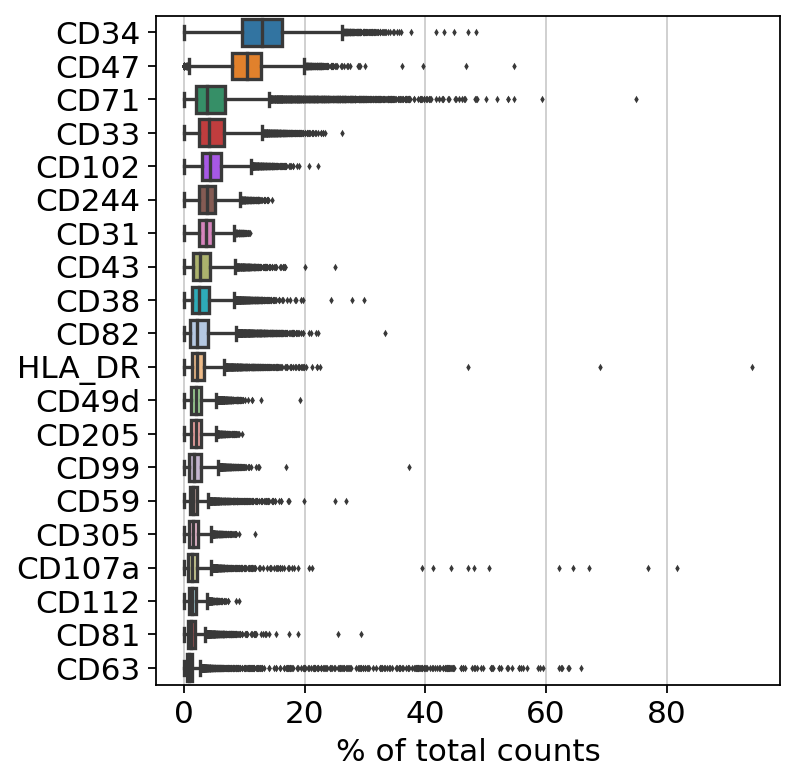

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [9]:
sc.pp.filter_cells(adata, min_genes=30) #they are not genes, but AB. The code is the same

filtered out 136 cells that have less than 30 genes expressed


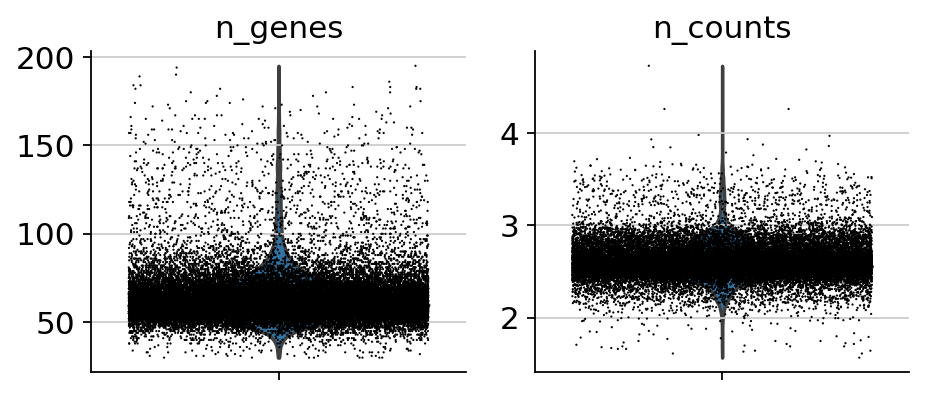

In [10]:
adata.obs['n_counts'] = np.log10(adata.X.sum(axis=1).A1) #they are not genes, but AB. The code is the same
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)

In [11]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [12]:
print(np.mean(adata.obs['n_counts']))
print(np.mean(adata.obs['n_genes']))

463.82468
64.59770075963104


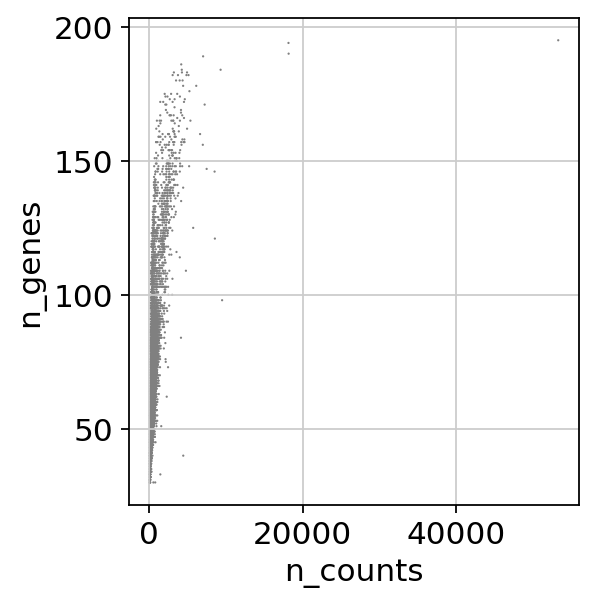

In [13]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [14]:
sc.pp.filter_genes(adata, min_cells=3)

In [15]:
adata

AnnData object with n_obs × n_vars = 29488 × 198
    obs: 'Tissue', 'batch', 'n_genes', 'n_counts'
    var: 'n_cells'

In [16]:
adata = adata[adata.obs["n_counts"] < 5000, :]

In [17]:
adata

View of AnnData object with n_obs × n_vars = 29470 × 198
    obs: 'Tissue', 'batch', 'n_genes', 'n_counts'
    var: 'n_cells'

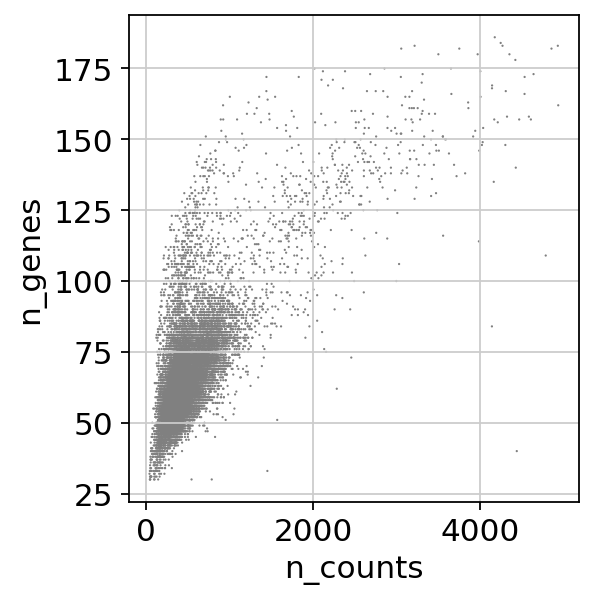

In [18]:
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [19]:
adata_qc=adata.copy()

In [20]:
adata_qc.write("h5ad_part1/20210119_part1_Laurenti_mq224_A_ADT_postQC_BM_SPL_SIGAB11_SIGAD11.h5ad")

In [21]:
import numpy as np
from sklearn.mixture import GaussianMixture
import anndata

cell_protein_matrix = adata_qc.copy()

### DSB METHOD - CLUSTERING AND VISUALIZATION

In [22]:
###########TEST: CAN WE GET RID OF THE BACKGROUND NOISE IN OUR PROTEIN DATA? DSB!

#SIGAD12_initial as the SUPER RAW

cell_protein_matrix = adata_initial[adata_qc.obs_names,:].copy()

#SIGAD12.shape

cell_protein_matrix.shape

(29470, 198)

In [23]:
# adata here must be the read in from raw umi matrix
#We need to define empty droplets. 
#You split out the data. You assign how many cells as empty droplets 
def getNegDroplets(adata, lamda=5): 
    #lamda controls how many empty droplets you will have in the end.
    #Its very hard to tell which is the numner of empty droplets.
    umi = np.log1p(np.sum(adata.X.toarray(), axis=1)) #umis per cell
    mu_umi = np.mean(umi) #mean of umi counts
    sd_umi = np.std(umi) #SD of the umi counts 
    print(mu_umi)
    print(sd_umi)
    sub_threshold = mu_umi-(lamda*sd_umi) 
    print(sub_threshold)
    plt.hist(umi, bins = 100)
    plt.axvline(x=sub_threshold,color='red')
    #Simplified version. They used Seurat function,  but we dont want that.
    #anything less than that would be empty droplets.
    return adata[umi<sub_threshold,:].copy()
    #any cell that has umi counts < threshold. 

6.0024734
0.466016
5.652961358428001
(4194, 198)


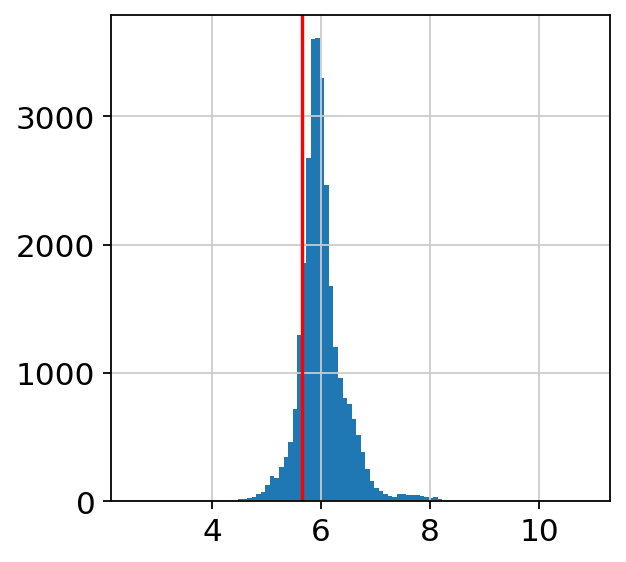

In [24]:
import matplotlib.pyplot as plt

empty_drop_matrix = getNegDroplets(adata_initial, lamda=0.75)
print(empty_drop_matrix.shape)

In [25]:
#renormalisation of the counts by empty droplets background.
#cell_protein_matrix and empty_drop_matrix are split from the same matrix,
#only difference is cells, but Ab is the same.
#cell_protein_matrix: adata object.
def DSB(cell_protein_matrix, empty_drop_matrix, pseudocount=10):
    adt = cell_protein_matrix.X.toarray() #meaningful cells xantibodies
    adtu = empty_drop_matrix.X.toarray() #the non meaninful - empty droplets 
    adt_log = np.log(adt+pseudocount) 
    adtu_log = np.log(adtu+pseudocount)
    mu_u = np.mean(adtu_log, axis=0) #for each protein in empty drop.
    sd_u = np.std(adtu_log, axis=0) #for each protein in empty drop.
    norm_adt = (adt_log-mu_u)/sd_u  #Y=log(Xi+P)-mu / sd
    adata_new = anndata.AnnData(X=norm_adt, obs=cell_protein_matrix.obs, var=cell_protein_matrix.var)
    #new normalised values
    print(adata_new.shape)
    cellwise_background_mean = np.array([]) #equation 2 from this line.
    for column in norm_adt.T:
        gmm = GaussianMixture(n_components=2) #for each protein
        gmm.fit(column.reshape(-1,1)) #you fit it
        cellwise_background_mean= np.append(cellwise_background_mean,gmm.means_[0])
        #you get the mean for the background
    print(len(cellwise_background_mean))
    adata_new.var['bg_mean'] = cellwise_background_mean #contains all the new normalised umi counts.
    #save it for the regression function, which we wont use!
    return adata_new

In [26]:
adata_new = DSB(cell_protein_matrix, empty_drop_matrix, pseudocount = 5)
cell_protein_matrix.shape

(29470, 198)
198


(29470, 198)

In [27]:
adata_new.raw = adata_new

adata_new1=adata_new.copy().T

adata_new2 = adata_new1.T

adata_new2.raw = adata_new

DSB_output0 = adata_new2.copy()

In [28]:
DSB_output0

AnnData object with n_obs × n_vars = 29470 × 198
    obs: 'Tissue', 'batch'
    var: 'bg_mean'

In [29]:
DSB_output0.raw = DSB_output0

In [30]:
DSB_output0.write("h5ad_part1/20210119_part1_Laurenti_mq224_ADT_postQC_DSB_BM_SPL_SIGAB11_SIGAD11.h5ad")

In [31]:
sc.tl.pca(DSB_output0, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


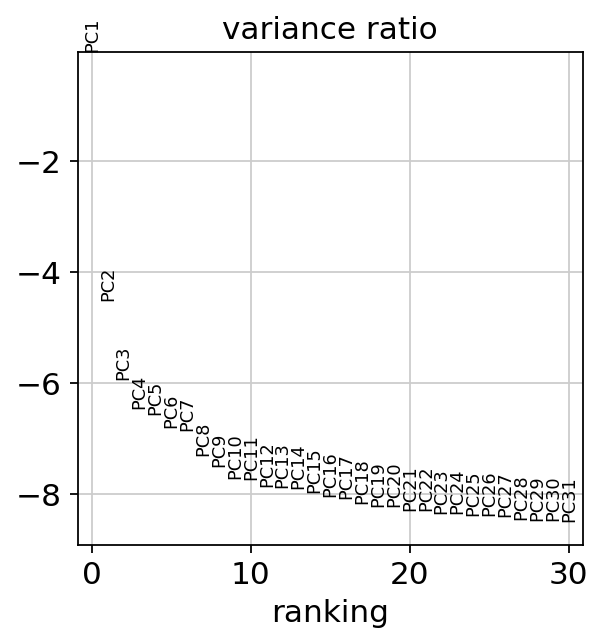

In [32]:
sc.pl.pca_variance_ratio(DSB_output0, log=True)

In [33]:
sc.pp.neighbors(DSB_output0, n_neighbors=40, n_pcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 10


/usr/local/lib/python3.7/dist-packages/numba/core/typed_passes.py:314: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../../../../../usr/local/lib/python3.7/dist-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/usr/local/lib/python3.7/dist-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../../../../.

    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


In [34]:
sc.tl.umap(DSB_output0)
sc.tl.draw_graph(DSB_output0)
sc.tl.leiden(DSB_output0, resolution=0.5)
sc.tl.louvain(DSB_output0, resolution=0.5)

computing UMAP


/usr/local/lib/python3.7/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:03:57)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:28)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:15)


In [35]:
DSB_output0.write("h5ad_part1/20210119_part1_Laurenti_mq224_ADT_postQC_DSB_FDG_BM_SPL_SIGAB11_SIGAD11.h5ad")

In [36]:
markers = ['CD19', 'IgG_Fc', 'CD45RA', 'CD81', 'IgM', 'CD10', 'CD22',
       'integrin_b7', 'CD24', 'CD105', 'CD72', 'CD9']

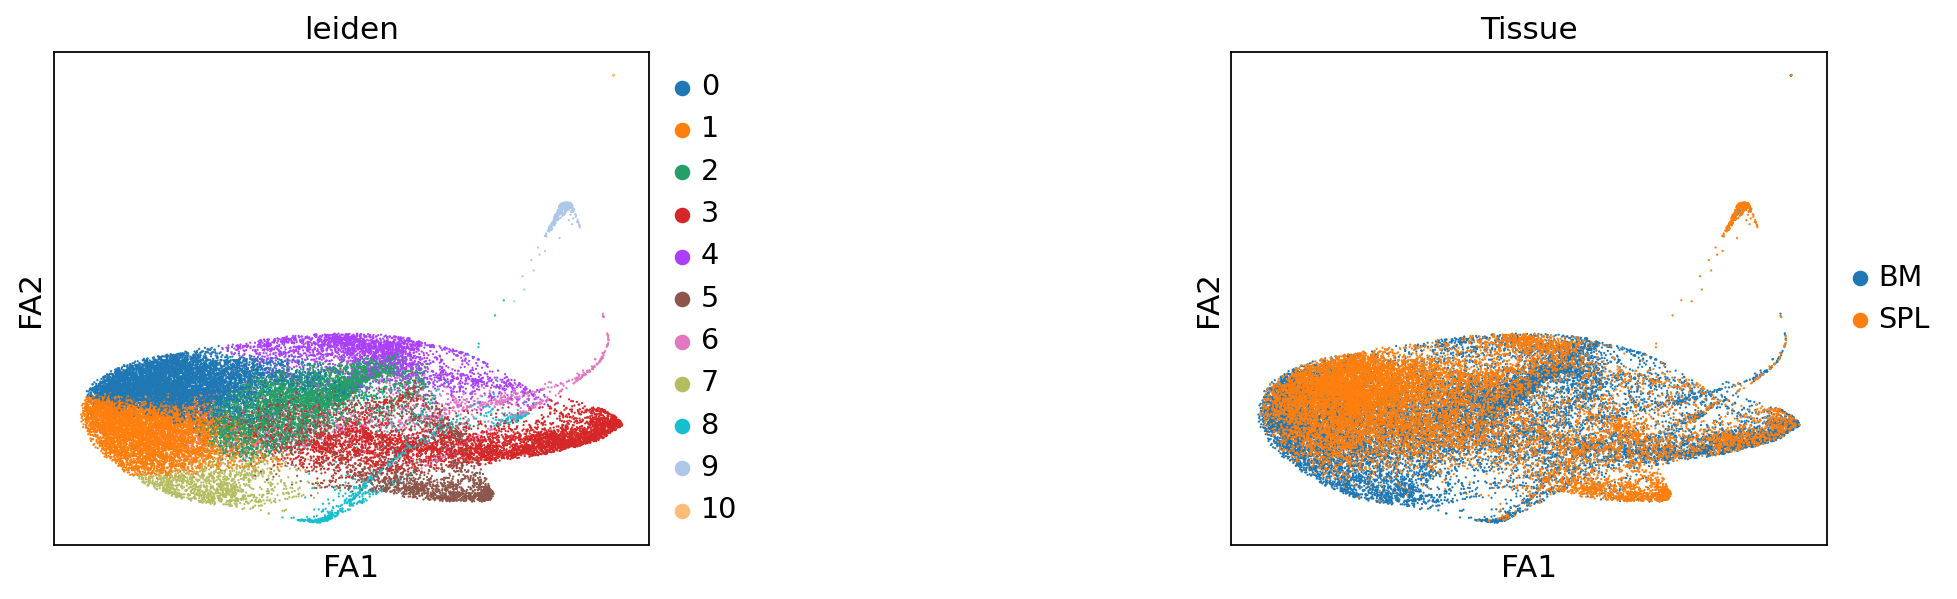

In [37]:
sc.pl.draw_graph(DSB_output0, color=['leiden','Tissue'], ncols=2, wspace = 0.8, cmap=cmap)